# Conditional GANs - Pix2Pix by `Mr. Harshit Dawar!`
* Can be used to generate the classes conditionally, i.e., we have the control over which classes we want to generate!
* It takes paired dataset as the input (source & target image pair).

In [9]:
# Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers as ly
import tensorflow as tf
import os
import time
from IPython import display
import pathlib

## Downlaoding the dataset & visualizing a random Image!

In [5]:
dataset_url = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz"

In [8]:
dataset_directory = tf.keras.utils.get_file(fname = "maps.tar.gz", origin = dataset_url, extract = True)

250242400/250242400 [==============================] - 572s 2us/step


In [11]:
# Creating a path object
dataset_path = pathlib.Path(dataset_directory)

In [29]:
# Checking the directory in the dataset downloaded
os.listdir(os.path.join(dataset_path.parent, "maps"))

['train', 'val']

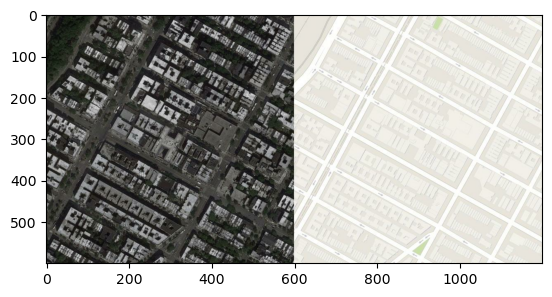

(600, 1200, 3)


In [49]:
# Reading a rando training image
image = tf.io.read_file(os.path.join(os.path.join(dataset_path.parent, "maps/train"), np.random.choice(os.listdir(os.path.join(dataset_path.parent, "maps/train")))))
image = tf.io.decode_jpeg(image)
plt.imshow(image)
plt.show()
print(image.shape)

## Data Processing & Visualization

In [50]:
# Function to laod & transform the image
def image_loader(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, [256, 512])    # This size for pix2pix compatibility
    
    # Taking half width to separate the image into satellite & map one
    width = image.shape[1] // 2
    
    satellite_image = image[:, : width, :]
    map_image = image[:, width :, :]
    
    satellite_image = tf.cast(satellite_image, tf.float32)
    map_image = tf.cast(map_image, tf.float32)
    
    return satellite_image, map_image

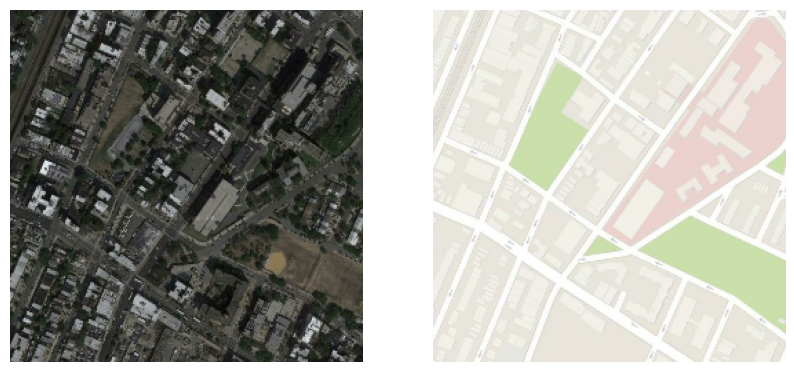

In [62]:
# Visualizing the transformed images 
satellite_image, map_image = image_loader(os.path.join(os.path.join(dataset_path.parent, "maps/train"), np.random.choice(os.listdir(os.path.join(dataset_path.parent, "maps/train")))))
fig, ax = plt.subplots(1, 2, figsize = (10, 9))

ax[0].imshow(satellite_image / 255.0)
ax[1].imshow(map_image / 255.0)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

In [79]:
# Function to resize the images
def resize_image(satellite_image, map_image, width, height):
    satellite_image = tf.image.resize(satellite_image, [width, height], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    map_image = tf.image.resize(map_image, [width, height], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return satellite_image, map_image

# Function to randomly crop the images
def random_crop_image(satellite_image, map_image, width, height):
    stacked_image = tf.stack([satellite_image, map_image], axis = 0)
    cropped_image = tf.image.random_crop(stacked_image, size = [2, width, height, 3])
    return cropped_image[0], cropped_image[1]

# Funciton to add random changes in the image
def add_random_jitter(satellite_image, map_image):
    satellite_image, map_image = resize_image(satellite_image, map_image, 256, 256)
    satellite_image, map_image = random_crop_image(satellite_image, map_image, 256, 256)
    
    # Randomly flipping 30% of the images left to right
    if tf.random.uniform(()) >= 0.7:
        satellite_image = tf.image.flip_left_right(satellite_image)
        map_image = tf.image.flip_left_right(map_image)
    
    return satellite_image, map_image

# Function to normalize the images
def normalize_image(satellite_image, map_image):
    satellite_image = ( satellite_image - 127.5 ) / 127.5
    map_image = ( map_image - 127.5 ) / 127.5
    return satellite_image, map_image